# OPTIMIZACIÓN DE LA SOLUCIÓN DE ECUACIONES DIFERENCIALES A TRAVES DE REDES NEURONALES

El objetivo de este cuaderno es explicar la solución del movimiento armonico simple a traves del uso de PINNS con funciones de densidad de probabilidad dinámicas.  

## Orden

* Explicación de la razón por la cual se están implementando funciones de densidad de probabilidad dinámicas.
* declaracion del problema.
* importación de librerias.
* declaración de la red neuronal.
* Declaración y explicación del conjunto de puntos sobre el cual se va a optimizar la función.
* Declaración de la función de perdida dentro del código.
* Condiciones de parada.
* Serialización de las soluciones y análisis de rata de aprendizaje.
* Análisis de los distintos parametros de los que depende el algoritmo

## Explicación de la razón por la cual se están implementando funciones de densidad de probabilidad dinámicas.

Para realizar esto es conveniente hablar de como es que las PINNs resuelven ecuaciones diferenciales. Esto se hara a tráves de una explicación de porque se usan redes neuronales; como es que estas resuelven ecuaciones diferenciales; el problema generado por el paso anterior y finalmente como es que se espera que las funciones de probabilidad de densidad dinámicas lo resuelvan.

Empezando con las redes neuronales, estás no son más que funciones con una gran cantidad de parametros que tienen la capacidad de acercarse mucho a las formas de otras funciones. Esto significa que para una cantidad adecuada de parametros/neuronas se debería poder obtener virtualmente cualquier función deseada. Lo anterior significa que a la hora de resolver una ecuación diferencial, con una red neuronal que tenga una cantidad adecuada de parámetros, se podrá obtener una función que satisfazca la ecuación diferencial. Adicionalmente, en este caso se están usando funciones diferenciables. Es decir que lo que se están usando redes neuronales porque se espera que estas tengan la capacidad de tomar la forma de la respuesta a la ecuación diferencial.

La pregunta que surge naturalmente es ¿Cómo lograr que la red tome la forma de la función deseada? Esto se realiza a tráves del uso del aprendizaje por descenso de gradiente estocástico. Este es el nombre de una familia de algoritmos que resuelve el problema a traves de variar una gran cantidad de parametros. Para realizar esto el algoritmo utiliza una función que le indique que tan bien funciona cada conjunto de parámetros. De está forma el algoritmo llega a los parámetros que maximicen la función anterior. 

La forma tradicional para realizar lo anteriormente descrito consiste en:
1. Seleccionar un conjunto de puntos aleatorios que pertenezcan al dominio donde se espera resolver la ecuación diferencial.
2. Evaluar que tan bien estos puntos cumplen la ecuación diferencial.
3. Evaluar que tan bien se cumplen las condiciones de frontera.
4. Actualizar los parametros para mejorar los puntajes de los puntos 2 y 3 a traves de descenso de gradiente.
5. Repetir el paso 1.

Para explicar el problema asociado a este procedimiento, hay que tomar en cuenta que una gran mayoria de las ecuaciones diferenciales usadas son homogeneas y tienen una cantidad infinita de respuestas posibles (la cantidad de respuestas en este caso es del tamaño del conjunto $\mathbb{R}^2$ porque la ecuación diferencial es de grado 2). desafortunadamente esto lleva a que existan muchas respuestas que resuelven la ecuación diferencial pero no las condiciones de frontera. Ejemplos de esto son  $y(x) = 0 \text{ ; } y(x) = cos (x) \text{ ; } y(x) = 0.1 sin(x) $. Lo anterior significa que se necesita resolver la ecuación diferencial que resuelva las condiciones de frontera. 

El método tradicional primero se acopla a las condiciones de frontera y luego propaga la ecuación diferencial al resto del dominio. Esto significa que no todas las partes del dominio se van a resolver de manera simultanea. Las regiones más cercanas a las condiciones de frontera se van a resolver antes que el resto. Después de que estas se resuelvan, debido a que se están usando funciones diferenciables, eventualmente se va a propagar la solución correcta al resto del dominio.

Lo anterior significa que si se están colocando puntos sobre las zonas en las cuales la solución no se ha propagado, se está perdiendo el tiempo y esfuerzo computacional. Consecuentemente se espera que al utilizar una función de densidad de probabilidad que no coloque los puntos de manera uniformemente repartida, sino solo cerca a las condiciones de frontera, se logre aumentar la velocidad de convergencia.

### To do
* Hablar de diferenciación automatica


## Problema
Se desea resolver la siguiente ecuación diferencial con las siguientes condiciones de frontera.
$$y'' = y$$
$$y(0) = 0$$
$$y(\frac{\pi}{2}) = 1$$
En el dominio
$${x : x\in \mathbb{R} ^ 1 :  x\in [0,7]}$$
Residual
Sea $y_r(x)$ la respuesta de la red neuronal a la entrada $x$ y $y_r''(x)$ la segunda respuesta de la derivada con respecto a x de la red se va a usar la siguiente función de perdida. Acá los puntos $x_i$ pertenecen a un conjunto $\mathbf{X}$ que sera descrito más adelante.
$$L = \sum_{i=1}^n{\Big(y_r''(x_i)-y_r(x_i)\Big)^2}+\alpha * (y_r(0)^2+(y_r(\frac{\pi}{2}) - 1)^2)$$

## Importación de las librerias
Se usan las siguientes librerias por las sigueintes razones
| libreria Usada | Razón |
|---|---|
|Torch|Ofrece documentación más accesible que Julia y tiene modos de diferenciación automatica que facilitan el trabajo|
|torch.nn|Con este modulo se declara la clase con la que se genera la red neuronal|
|matplotlib|Graficación |
|random|Generación de puntos con una distribución Normal|
|time|Seguimiento del tiempo tomado por cada proceso |
|Typing|Generación de listas con tipos de datos estáticos|
|pickle|serialización y guardado de variables|
|OS| manejo de carpetas|

In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import random as rd
import numpy as np
import time
from typing import List
import pickle
import os 

## Declaración de la red neuronal

Se va a usar una red normal con 5 capas de 50 neuronas

In [2]:
os.chdir("/home/UANDES/n.grandas/pythontesis/pythontesis/v5") # Esta linea hace que el cuaderno corra sobre el directorio deseado
device = "cuda" # Esta linea hace que el cuaderno se ejecute con la gpu de envidia
dtype = torch.float64 # Esta linea hace que el tipo de dato sean floats de 64 bits
estaResolviendo = True # Esta variable se usa para controlar si se quiere que se resuelvan las redes neuronales.
# Se pone en false si no se desea resolver nada.
buscandoLearningRate = False # Esta variable se usa para controlar si se requiere hacer el analisis de learning rate.
# como este analisis toma mucho tiempo, el default es falso


class NeuralNetworkPrueba(nn.Module): # Acá se declara el tipo de red que se va a usar
    def __init__(self):
        super(NeuralNetworkPrueba, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

redDinamica = NeuralNetworkPrueba().to(device) # Acá se declara la función de la red neuronal y se pone a correr en gpu

RuntimeError: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW

## Declaración y explicación del conjunto de puntos sobre el cual se va a optimizar la función.

### Orden interno
1. Introducción y justificación para la exitencia del algoritmo
2. Variables usadas en el algoritmo
3. Funciones usadas en el algoritmo
4. Algoritmo
5. Explicación del algoritmo

### Introducción y justificación para la exitencia del algoritmo

Para empezar hay que tomar en cuenta que una gran mayoria de las ecuaciones diferenciales usadas son homogeneas y tienen una cantidad infinita de respuestas posibles (la cantidad de respuestas en este caso es del tamano de $\mathbb{R}^2$ porque la ecuación diferencial es de segundo grado ). desafortunadamente esto lleva a que la respuesta $y = 0$ sea una solución para estas ecuaciones. En este caso la respuesta que queremos es diferente de 0 y está dada a partir de las condiciones de frontera. 

A la hora de resolver la ecuación diferencial mediante PINNs hay que escoger un conjunto de puntos sobre el cual se va a optimizar la función. El acercamiento predeterminado para PINNs es escoger varios sets de puntos aleatorios en el dominio. No obstante, en experimentación previa se noto que esto es un proceso poco eficiente. Esto se debe a que el optimizador va a intentar llevar los puntos hacia la solución de la ecuación diferencial más cercana. Lo anterior significa que en las etapas iniciales de la optimización los puntos lejanos a las condiciones de frontera van a converger a soluciones que si bien pueden pertenecer al conjunto de soluciones de la ecuación diferencial, no son la ecuación diferencial que se necesita. Esto lleva a que se este optimizando parametros para llegar a una forma inutil. Con el objetivo de eliminar este problema se propone el siguiente método

Para resolver el problema anterior se propone un método en el cual no se resuelven los puntos que esten alejados de las condiciones de frontera hasta que la solución de la ecuación diferencial se acerque a ellos. Para lograr esto se propone empezar con puntos que esten cercanos a la condición de frontera inicial e ir moviendo estos puntos de prueba mientras se va a resolviendo la ecuación diferencial. De esta forma se espera que todos los puntos convergan a la solución esperada y no a otra posible  solución de la ecuación diferencial. A continuación se detalla el algoritmo para la selección De estos puntos.

### Variables usadas en el algoritmo



|Variable|valor Inicial|Interpretación|
|---|---|---|
|$\mu$|0|Es el punto en el cual se encuentra el solucionador, es una variable que varia mientras avanza el solucionador|
|$\sigma$|0.2|Es la desviación estandar con la cual se ponen puntos cerca a la frontera definida por $\mu$|
|$n_{max}$|200|Es el largo máximo que puede tener el conjunto $\mathbf{X}$|
|$n_{ret}$|60|El numero de puntos que se borran del conjunto $\mathbf{X}$|
|$n_{pas}$|50|El numero de puntos que se añaden al conjunto $\mathbf{X}$|
|$n_{ini}$|20|Numero de puntos con los cuales se inicializa el conjunto $\mathbf{X}$|
|$c_1$|$10^{-6}$|Un coeficiente que define linealmente que tan rapido se avanza con respecto a la rata de solución |
|$c_2$|1|Un criterio para definir la agresividad con la cual se quiere avanzar con respecto a la solución|
|$L_i$|dinamico|Valor de la perdida obtenida en la iteración i|
|$x_{inf}$|0|Limite inferior del dominio sobre ,el cual se va a resolver la ecuación diferencial|
|$x_{sup}$|0|Limite superior del dominio sobre ,el cual se va a resolver la ecuación diferencial|

### Funciones usadas en el algoritmo
1. Funcion limitadora del dominio:

    Esta es una función hecha para que si el algoritmo recorre todo el dominio sin converger, este pueda volver al punto inicial  $l : \mathbb{R}\rightarrow \mathbb{R}.$ $$ l(x) = mod(x_{sup}-x_{inf},x-x_{inf})+x_{inf} $$
2. relación generadora de puntos
    f ($\mu $,$\sigma$) retorna un punto aleatorio con distribución normal de promedio $\mu$ y desviación estandar $\sigma $

### Algoritmo

Se inicializan los siguientes valores en $\mu _0 = 0, \sigma = 0.05, c_1 = 1e-6, c_2 = 1$. Luego de esto se inicializa un conjunto con $n_{ini}$ puntos repartidos uniformemente a traves del dominio. Estos puntos solo estan para asegurar que la perdida sea diferente de 0 en el primer momento de la optimización.
Despues de esto para cada momento i+1 en el tiempo
1. Se define $ \mu_{i+1} = \mu_{i} + \frac{c_1}{L_i^{c_2}} $
2. Se genera un punto nuevo tal que $ x_{i+1} = l(g(\mu_{i+1},\sigma))$
3. Se anade el elemento $x_{i+1}$ al conjunto $\mathbf{X}$
4. Si $|\mathbf{X}|>n_{max}$ aleatoriamente se retiran $n_{ret}$ elementos del conjunto.
5. Si se retiran elementos del conjunto, Se anaden $n_{pas}$ elementos al conjunto. Cada uno de estos elementos se elige como un numero aleatorio entre 0 y $\mu_{i+1}$
6. Se guarda el valor de $L(x_{i+1})$


### Explicación de los pasos del algoritmo
<i>Se eligen los valores del paso 0 a partir de un poco de prueba de error, se esta realizando una aproximación numerica con polinomios de chebyscheff para justificar mejor la elección de estos parametros. </i>

Para empezar hay que tener en cuenta que el algoritmo divide sobre el valor de la perdida. Para evitar que este valor empiece en 0, se eligen 20 puntos repartidos aleatoriamente dentro del dominio. Despues de esto, se va a empezar el proceso de anadir puntos. Un indicador de que tan bien se esta resolviendo la ecuación diferencial es la función de perdida. Consecuentemente se quiere que los puntos avancen cuando disminuya la función de perdida. Por esto se tomo $\Delta \mu  = \frac{c_1}{L^c_2}$ . 

Desafortunadamente el algoritmo hasta ese punto aumenta significativamente la complejidad computacional en el tiempo del problema. Esto se debe a que la velocidad de las epocas de entrenamiento depende linealmente del largo del conjunto. Consecuentemente no es ideal aumentar el largo del conjunto de forma indefinida y proporcional a las epocas de entrenamiento. Es por esto que en el paso 4 se introduce un filtro tal que el tamaño del conjunto sea limitado.

Este filtro no es un filtro tan convencional, se eliminan más puntos de los que se añaden. Esto se debe a que si se añadiera la misma cantidad de puntos que se elimina, en promedio la cantidad de puntos cerca a la frontera se reducirian en una proporción $n_{ret}/n_{max}$ con cada iteración. A traves de experimentación se noto que estos puntos se reducian de manera excesivamente rápida. Esto es resuelto haciendo que despues del filtro el tamano del conjunto sea unas unidades (10 unidades funciona) menor al limite impuesto por $n_{max}$. De esta forma la cantidad de puntos cerca a la fronterea se reduciran en una proporcion menor. Esta proporcion la indica la ecuación a continuación.

Despues de una reducción de puntos del paso 4 en la iteración i+1 se espera que la proporción de puntos cerca a la frontera sea reducida. Para expresar esto, la cantidad de puntos cercanos a la frontera seran representados por la variable $\eta_{i+1}$. Estos se reduzca de la siguiente forma: $$\frac{\eta_{i+1}}{\eta_{i}} = \frac{n_{ret}}{n_{max}}$$ No obstante, dado que este paso solo ocurre cada $n_{ret} - n_{pas}$ actualizaciones, el cambio esperado por la proporción de puntos estaría dado por la siguiente formula.

$$\eta_{i+n_{ret} - n_{pas}} = n_{ret} - n_{pas} + \frac{n_{ret}}{n_{max}} * \eta_{i}$$

De esta forma el limite cuando i tiende a infinito, el numero de puntos cerca a la frontera no tiende a 0. <i><b>¿valdría la pena colocar una gráfica de como i converge a un valor diferente de 0?</b></i>

Adicionalmente, se estan añadiendo puntos nuevos en zonas que en teoría ya fueron resueltas. Si bien este acercamiento pareceria reducir la eficiencia del algoritmo, hay que tomar en cuenta que el problema esta siendo resuelto mediante metodos de descenso de gradiente. Consecuentemente con el objetivo de que al resolver puntos actuales no se eliminen los resultados anteriores, se colocan puntos en las soluciones anteriores. De esta forma, cuando se altere la respuesta de la red en puntos anteriores, el descenso de gradiente las devolvera a la solución anterior. 

#### Falta explicar
 * Uso de funciones de peso
 * por que se usan los numeros de largo del vector, retiro y posicion de puntos.
 * Tradeoff entre velocidad y estabilidad

In [3]:
puntos = torch.linspace(0,7,20, device = device) #Inicialización de los puntos de prueba
puntos.requires_grad = True # Atributo que indica que estos puntos se usan para la optimización 
perdidavar = 1e9 #Variable posicionada acá para que quede fuera del espacio de memoria de las funciones siguientes
promAct = 0  # Lo mismo que arriba
xsup = 7 # limite superior del dominio

def limitador(x):
    xint = x
    while (xint>xsup):
        xint -= xsup
    return xint
    
c2 = 1
c1 = 1e-6 #este coeficiente es para alentizar el avance con respecto a la función de perdiad
sigma = 0.2
def actualizarPuntos():
    # Esta función va actualizar los puntos. Para mantener un balance entre puntos nuevos y puntos anteriores
    #  tambien va a cubir el espacio recorrido por puntos anteriores. Un objetivo de esta función es correr 
    # con un numero bajo de puntos
    global perdidavar,puntos,puntosCreados,promAct,c1,c2,sigma
    
    nuevosPuntos = puntos.detach().tolist()
    promAct = limitador(promAct+c1/(perdidavar*len(puntos))**c2)  # acá se da el avance en promedio
    #print("promedio actual ", promAct)
    #print("perdida actual  ", perdidavar)
    #print("avance          ", coeficiente/perdidavar*len(puntos))
    nuevoPunto = max(min(rd.normalvariate(promAct,sigma),xsup),0) # acá se da el avance como una distribución normal
    nuevosPuntos.append(nuevoPunto)    
    tamTensor = 120
    borra = 60
    anade = 50
    if len(nuevosPuntos)>tamTensor:
        for i in range(borra):
            indice = rd.randint(0,tamTensor-borra-2)
            nuevosPuntos.pop(indice)
        for i in range(anade):
            nuevosPuntos.append(rd.uniform(0,promAct))
    puntos = torch.tensor(nuevosPuntos,device = device)
    puntos.requires_grad = True

pesos = [1]*20
def actualizarPuntosConPesos():
     # Esta función va actualizar los puntos. Para mantener un balance entre puntos nuevos y puntos anteriores
    #  tambien va a cubir el espacio recorrido por puntos anteriores. Un objetivo de esta función es correr 
    # con un numero bajo de puntos
    global perdidavar,puntos,puntosCreados,promAct,c1,c2,sigma, pesos
    if isinstance(pesos,List):
        nuevosPesos = pesos.copy()
    else:
        nuevosPesos = pesos.detach().tolist()
    nuevosPuntos = puntos.detach().tolist()
    promAct = limitador(promAct+c1/(perdidavar/len(puntos))**c2)  # acá se da el avance en promedio
    nuevoPunto = max(min(rd.normalvariate(promAct,sigma),xsup),0) # acá se da el avance como una distribución normal
    nuevosPuntos.append(nuevoPunto) 
    nuevosPesos.append(1)   
    tamTensor = 40
    borra = 20
    anade = 10
    if len(nuevosPuntos)>tamTensor:
        for i in range(borra):
            indice = rd.randint(0,tamTensor-borra-2)
            nuevosPuntos.pop(indice)
            nuevosPesos.pop(indice)
        for i in range(anade):
            nuevosPuntos.append(rd.uniform(0,promAct))
            nuevosPesos.append(20)
    puntos = torch.tensor(nuevosPuntos,device = device)
    puntos.requires_grad = True
    pesos = nuevosPesos



## Declaración de la función de perdida dentro del código
### Orden
1. Problema a Resolver
2. Notas de la función de perdida

### Problema
#### Este problema fue copiado y pegado de la sección inicial

Se desea resolver la siguiente ecuación diferencial con las siguientes condiciones de frontera.
$$y'' = y$$
$$y(0) = 0$$
$$y(\frac{\pi}{2}) = 1$$
En el dominio
$${x : x\in \mathbb{R} ^ x\in {0,7}}$$
Residual
Sea $y_r(x)$ la respuesta de la red neuronal a la entrada x y $y_r''(x)$ la segunda respuesta de la derivada con respecto a x de la red se va a usar la siguiente función de perdida. Acá los puntos $x_i$ pertenecen al conjunto $\mathbf{X}$.
$$L = \sum_{i=1}^n{(y_r''(x_i)-y_r(x_i))^2}+\alpha * (y_r(0)^2+(y_r(\frac{\pi}{2}) - 1)^2)$$ 

### Notas de la función de perdida.
Para empezar hay que notar que se estan usando tecnicas de aprendizaje profundo. En general estas tecnicas dependen de optimizar una función con una gran cantidad de parametros a traves de su gradiente. Para evitar que esto sea un problema significativo en terminos de complejidad computacional se usa un algoritmo de diferenciación automatica para que la complejidad de generar el vector gradiente no dependa de la dimensión del vector gradiente.

Lo anterior significa que se tiene que usar una implementación que tenga en cuenta la diferenciación automatica, para esto se usa Pytorch. El requisito que pide esta libreria es que se indiquen cuales variables van a ser necesitadas a la hora de la diferenciación. Estas están identificadas con el atributo requires_grad = True

### Paralelización
La función que genera cálcula la perdida deberia de correr en tiempo $O(1)$ para ciertos $n_{max}$, pues esta corriendo en GPU y se supone que hay al menos 3000 nucleos libres, este no es el caso. Debido a la restricción GIL de python, que no permite utilizar más de un hilo en simultaneo, no fue posible lograr que la esta función corra adecuadamente. Se intento utilizar torchscript de forma extensiva, este es un sublenguaje de python que corre en C y en teoría podia paralelizar. Desafortunadamente este lenguaje no pudo mantener los arboles asociados a la diferenciación avanzada para las derivadas de segundo grado. Consecuentemente fue utilizada una versión sin paralelismo que corria en tiempo $O(n)$. 

In [4]:
def perdida2():
    global perdidavar # esta variable guarda la perdida en una ubicación afuera de la función.
    x0 =  torch.tensor([0.0],device=device,requires_grad =True) # Ubicación en X de la primera condición de frontera
    # el 0.0 es importante para que pytorch lo identifique como un float.
    # acá el argumento device se usa para indicar que el vector debe guardarse en la memoria de la gpu
    # Acá el rgumento requires_grad = true se usa para indicar que la variable importa a la hora de la diferenciación 
    xPi = torch.linspace(3.14159/2,1,2,device = device) 
    xPi =  torch.tensor([xPi[0]],device=device,requires_grad =True) # Ubicación en X se la segunda condición de frontera
    suma = 0
    for j in puntos:
        i = torch.tensor([j],device=device,requires_grad =True) 
        # hay que meter el valor en X dentro de un vector para que pytorch lo tome como una operación de algebra lineal
        # lo anterior es necesario con la función nn.Sequential()
        y = redDinamica(i) 
        yprima=torch.autograd.grad(y,i,create_graph=True)[0]
        yprimaprima=torch.autograd.grad(yprima,i,create_graph=True)[0]
        suma+=(yprimaprima+y)**2
    # Acá se usa alpha = 100
    suma+=100*(redDinamica(x0))**2
    suma+=100*(1-redDinamica(xPi))**2
    perdidavar = suma
    return suma

def perdidaConPesos():
    global perdidavar # esta variable guarda la perdida en una ubicación afuera de la función.
    x0 =  torch.tensor([0.0],device=device,requires_grad =True) # Ubicación en X de la primera condición de frontera
    # el 0.0 es importante para que pytorch lo identifique como un float.
    # acá el argumento device se usa para indicar que el vector debe guardarse en la memoria de la gpu
    # Acá el rgumento requires_grad = true se usa para indicar que la variable importa a la hora de la diferenciación 
    xPi = torch.linspace(3.14159/2,1,2,device = device) 
    xPi =  torch.tensor([xPi[0]],device=device,requires_grad =True) # Ubicación en X se la segunda condición de frontera
    suma = 0
    contador = 0
    for j in puntos:
        i = torch.tensor([j],device=device,requires_grad =True) 
        # hay que meter el valor en X dentro de un vector para que pytorch lo tome como una operación de algebra lineal
        # lo anterior es necesario con la función nn.Sequential()
        y = redDinamica(i) 
        yprima=torch.autograd.grad(y,i,create_graph=True)[0]
        yprimaprima=torch.autograd.grad(yprima,i,create_graph=True)[0]
        suma+=pesos[contador]*(yprimaprima+y)**2
        contador +=1
    # Acá se usa alpha = 100
    suma+=100*(redDinamica(x0))**2
    suma+=100*(1-redDinamica(xPi))**2
    perdidavar = suma
    return suma

## Condiciones de parada

Se van a usar dos condiciones de parada, la primera va a ser con respecto al tiempo y la segunda va a ser con respecto a un criterio de calidad 

### Tiempo

Para la condición de parada con respecto al tiempo se pondra un limite de 1.75 horas por caso de solución. Este criterio esta ahí porque el computador con el cual se resuelve este problema no esta disponible de forma ilimitada. Consecuentemente se desea que si se pasa el limite de tiempo por lo menos se guarden las respuestas y avances.

### Criterio de calidad

La segunda condición de parada va a ocurrir en caso de que la perdida promedio para cada punto sea de 0.001. Para evitar evaluar dos veces la misma función se guarda el primer resultado y se usa en el segundo <b>Este numero fue escogido arbitrareamente. Creo que funciona bien pero no tengo ni idea de como justificar esta elección</b>

<b> Hacer cambio para que no se calcule dos veces el check</b>

In [5]:
# Puntos Prueba : 
puntosPrueba = torch.linspace(0,7,400,requires_grad=True)
varPerdidaCondicionParada = 1e9

def perdidaParaRevisar():
    global varPerdidaCondicionParada
    with torch.no_grad():
        suma = 0
        for j in puntosPrueba:
            i = torch.tensor([j],device=device)
            y = redDinamica(i)
            suma += torch.abs(y-torch.sin(j))
    varPerdidaCondicionParada = suma
    return suma

def revisador():
    return varPerdidaCondicionParada<0.01*len(puntosPrueba)

## Serialización de soluciones y análisis de rata de aprendizaje.
La serialización es el proceso mediante el cual se guardan algunas variables para que en análisis futuros se puedan usar sin necesitar correr todo el código. 
### subclases de pytorch
Los objetos de pytorch que se van a serializar vienen con un método que lo permite hacer de forma sencilla. En este caso se usa este método (save_state_dict())
### Resto de objetos
En este caso se usa la libreria Pickle para este proposito. Para serializar primero se debe abrir un archivo que contenga la información. Para esto se utiliza la estructura try/except. esta va a intentar crear y abrir un archivo con el nombre en filename, si esto falla intentara editar sobre un archivo con ese nombre.

In [7]:
if estaResolviendo:
    os.chdir("/home/UANDES/n.grandas/pythontesis/pythontesis/v5")
    filename = "RESULTADOS/registrosPerdidas/registro.tesis"
else:
    os.chdir("/home/UANDES/n.grandas/pythontesis/pythontesis/basura")
    filename = "RESULTADOS/registrosPerdidas/registro.tesis"


try:
    archivo = open(filename,"xb")
except:
    archivo = open(filename,"wb")


## Análisis de los distintos parametros de los que depende el algoritmo.
### Orden 
1. Tasa de aprendizaje

### Tasa de aprendizaje

En la siguiente celda se prueban 20 tasa de aprendizaje distribuidas logaritmicamente entre $10^{-2}$ y $10^{-5}$. los resultados de esto con el registro de las perdidas para cada tasa de aprendizaje quedan serializados en el siguiente orden.

1. Separador llamado "tasa de aprendizaje"
2. tasa de aprendizaje
3. registro de la evolución de la perdida con respecto al tiempo
4. Indicador de que termino o no termino
5. Tiempo en el que termino
 

In [8]:
if buscandoLearningRate:
    for learningRate in list(np.logspace(np.log10(5e-2),np.log10(1e-6),18)):
        pickle.dump("rata de aprendizaje",archivo) # Escribe un flag dentro del archivo de serialziación
        pickle.dump(learningRate,archivo) # Escribe la tasa de aprendizaje
        optimizer = torch.optim.Adam(redDinamica.parameters(), lr=learningRate) # Se reinicializa el optimizador para cada ciclo
        registro_perdida=[]
        tiempoInicial = time.time()
        i = 0 # i mantiene la cuenta de cuantas epocas se están resolviendo
        termino = False
        while time.time()-tiempoInicial<3600*1.75 and not termino and estaResolviendo:
            # Compute prediction and loss
            loss = perdidaConPesos()
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 10 == 0:
                #print(loss.item()/len(puntos))
                #print("supermax",promAct)
                actualizarPuntosConPesos()
            if i % 20 == 0:
                registro_perdida.append(perdidaParaRevisar().item()/len(puntos))
                termino = revisador()
            if i % 300 == 0:
                torch.save(redDinamica.state_dict(),"RESULTADOS/estados/senoParalelo"+str(i)+" epochs"+str(round(np.log10(learningRate),2))+".tar")
            i+=1
        pickle.dump(registro_perdida,archivo)
        if termino:
            pickle.dump("termino en",archivo)
            pickle.dump(time.time()-tiempoInicial,archivo)
        torch.save(redDinamica.state_dict(),"RESULTADOS/terminados/senoParaleloFinales"+str(np.log10(learningRate))+".tar")
        print(learningRate)
        print(i)
        redDinamica = NeuralNetworkPrueba().to(device)
archivo.close()
c1 = 1e-5
c2 = 1
sigma = 0.05

In [9]:
pesos

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

### Analisis de la tasa de aprendizaje

<b> la siguiente celda esta mal porque hay un error en el solucionador que llame para generar los datos. Este error ya fue corregido y se estan generando nuevos datos</b>

['senoParalelo3600 epochs-3.58.tar', 'senoParalelo900 epochs-3.58.tar', 'senoParalelo3300 epochs-3.58.tar', 'senoParalelo3000 epochs-3.58.tar', 'senoParalelo2400 epochs-3.58.tar', 'senoParalelo2700 epochs-3.58.tar', 'senoParalelo1200 epochs-3.58.tar', 'senoParalelo300 epochs-3.58.tar', 'senoParalelo2100 epochs-3.58.tar', 'senoParalelo1800 epochs-3.58.tar', 'senoParalelo600 epochs-3.58.tar', 'senoParalelo1500 epochs-3.58.tar', 'senoParalelo0 epochs-3.58.tar']


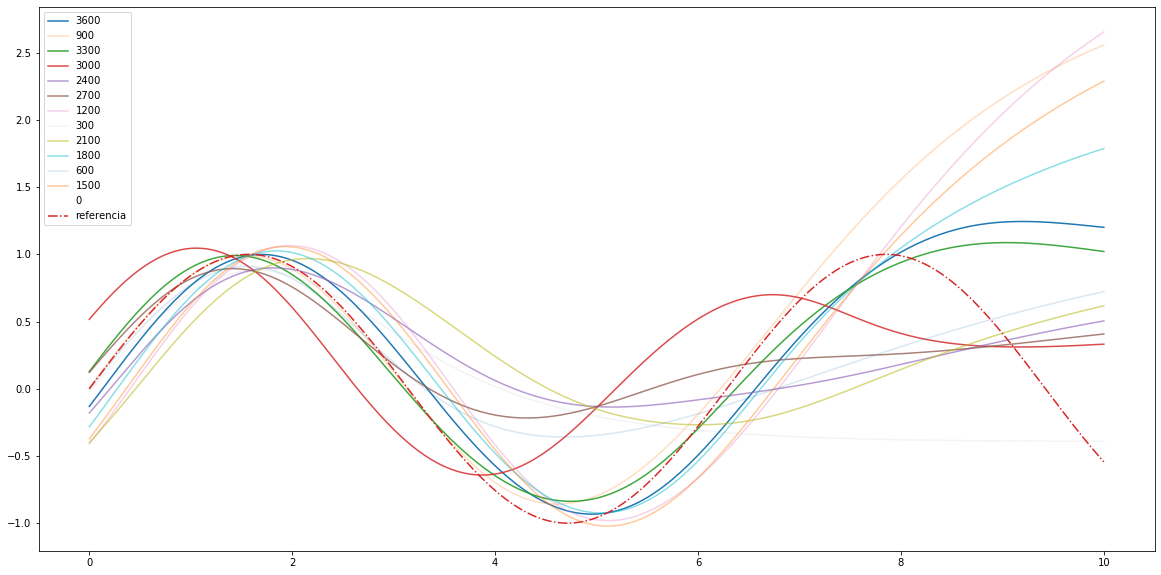

In [10]:
os.chdir("/home/UANDES/n.grandas/pythontesis/pythontesis/v4/RESULTADOS/estados")
archivos = [archivito for archivito in os.listdir() if archivito[-8:]=="3.58.tar"  ]
print(archivos)
plt.figure(figsize = (20,10))
alpha = 0
for nombre in archivos:
    redDinamica.load_state_dict(torch.load(nombre))
    ygrafica = []
    puntosGrafica = torch.linspace(0,10,250)
    for i in puntosGrafica:
        ytemp=redDinamica(torch.tensor([i],device = device))
        ygrafica.append(ytemp.cpu().detach().numpy()[0])
        #ygrafica.append(ytemp.detach().numpy()[0])
    import numpy as np
    puntosGrafica = np.linspace(0,10,250)
    if nombre != 'senoParalelo0 epochs-3.58.tar':
        epoca = int(nombre[12:16])
    else:
        epoca = 0
    alpha = epoca/3600
    plt.plot(puntosGrafica,ygrafica,label = epoca,alpha = alpha)
    
plt.plot(puntosGrafica,np.sin(puntosGrafica),label = "referencia",LineStyle="-.")
plt.legend()

### Proceso de optimización

Se va a optimizar para encontrar como el tiempo que toma llegar a una solución es afectado por las siguientes variables. Dado que el tiempo que toma llegar a una solución es una variable no deterministica, no se considera que sea apropiado usar metodos que utilicen gradiente para esta optimización. Esto se debe a que las gradientes que se van a encontrar van a estar fuertemente influenciadas por el ruido. Para remediar esto se va a optimizar a partir de interpolaciones con procesos iterativos de polinomios de chebyscheff. Esto se va a explicar a continuación.

* Rata de aprendizaje de ADAM
* $\sigma$
* $c_1$
* $c_2$


### Punto de chebyscheff

Para el proceso de interpolación se utilizará el método de interpolación de lagrange. Este método generea una un polinomio $p_n(x)$ de grado n cuyo valor es igual a una función $f(x)$ en al menos n puntos. Los puntos en los cuales son iguales se pueden elegir, deben ser diferentes entre sí y estan representados en el siguiente conjunto {$x_0 , ... , x_n$}. Dado que la interpolación no necesariamente es exacta para todos los puntos dentro del dominio, puede existir un error para ciertos puntos del dominio. La elección de los puntos afecta significativamente la distribución del error dentro de la función. A continuación se describe la formula asociada al error numérico por aproximación polinomial y la razón por la cual se eligen los puntos de chebyscheff. 


$$f(x) - p_n(x) = \frac{f^{(n + 1)}(\xi)}{(n+1)!} \blue {\prod_{i=0}^n{x-x_i}} $$

En la formula anterior $\xi$ es un punto dentro del intervalo de interpolación. Actualmente no se conoce cual punto es ni como asignarlo a algún punto deseado. Consecuentemente la unica parte controlable es la que esta resaltada en azul. Los puntos que minimizan el valor de la multiplicatoria son los puntos de chebyscheff. La comprobación de esto se puede encontrar en está <a href = https://math.okstate.edu/people/binegar/4513-F98/4513-l16.pdf > página </a>. Dado que se esta minimizando la parte controlable del error, se considera que se está minimizando el error. la formula para los puntos ${x_0,..., x_n}$ se encuentra a continuación.

Para cada punto $x_i$ en el intervalo [-1,1]

$$x_i = cos (\frac{\pi (k + 0.5)}{n}) \text{ para } k = 0,...,n $$

Para pasar al intervalo [a,b] se introduce la transformación $t(x) = \frac{a + b + (b-a)x}{1}$  que lleva a la siguiente expresión.

$$x_i = \frac{a + b + (b-a)*cos (\frac{\pi (k + 0.5)}{n})}{2} \text{ para } k = 0,...,n $$



## Implementación de los puntos de chebyscheff y optimización de parametros

La implementación del algoritmo de optimización propuesto se hace de la siguiente forma
1. Se define la función que da los puntos de chebyscheff
2. Se Prueba el algoritmo para encontrar el minimo de la función $f(x) = \frac{1}{1+(x-1)^2}$ cuyo minimo esta en $x = 1$
3. Se implementa el algoritmo para encontrar el parametro $c_2$ que menos tiempo toma para converger
4. Se implementa el algoritmo para encontrar el parametro $c_1$ que menos tiempo toma para converger
5. Se implementa el algoritmo para encontrar el parametro $\sigma$ que menos tiempo toma para converger. 
6. Se implementa el paso 3, 4 y 5 dos veces más para ya que $\sigma$, $c_1$ y $c_2$ deberían depender entre si.


### Implementación de la función de puntos y Prueba del algoritmo

Minimo Encontrado 0.5357142857142857
extremos [0.2732142857142857, 0.7982142857142858]
cantida de puntos de prueba 6
grado del polinomio 5


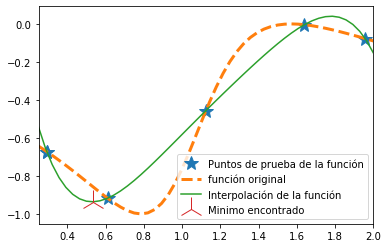

Minimo Encontrado 0.7660714285714287
extremos [0.6873214285714287, 0.8448214285714287]
cantida de puntos de prueba 6
grado del polinomio 5


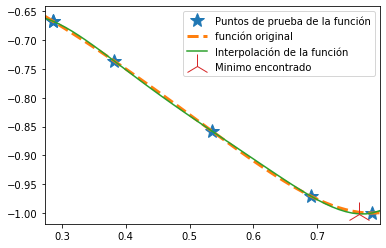

Minimo Encontrado 0.7837500000000002
extremos [0.7601250000000002, 0.8073750000000002]
cantida de puntos de prueba 6
grado del polinomio 5


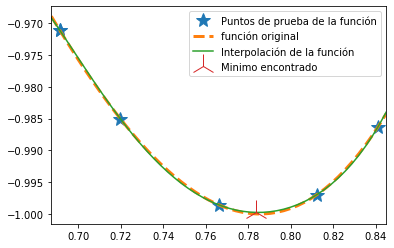

Minimo Encontrado :  0.7837500000000002
Minimo Teorico :  1
Error          :  -0.21624999999999983


In [12]:
def puntos_chebyscheff(n,a,b):
    inicializacion = np.array(range(n+1))
    inicializacion = np.flip(inicializacion)
    return (a +b + (b-a)*np.cos(np.pi/n*(inicializacion + 0.5)))/2

# Demostración del método de optimización
extremoInferiorIntervalo = 0.25
extremoSuperiorIntervalo = 2
minimoEnRonda : np.float128 = 3
for rondaDeOptimizacion in range(3):
    anchoIntervalo = extremoSuperiorIntervalo - extremoInferiorIntervalo
    tiemposTomados = []
    valores = puntos_chebyscheff(5,extremoInferiorIntervalo,extremoSuperiorIntervalo)
    f_prueba = lambda x: -(1/(1+(np.tan(x)-1)**2))
    for valor in valores:
        # redefinición de la función de actualización con el nuevo valor

        # Generación de variable con el tiempo de referencia para la nueva solución.
        # Solución con el nuevo valor.

        # Toma del tiempo de la solución.
        tiemposTomados.append(f_prueba(valor))
        pass

    # Interpolación polinomica con los tiempos de la nueva solución.
    
    interpolacion = np.polynomial.Polynomial.fit(valores,tiemposTomados,len(valores)-1)
    
    x_grafica = np.linspace(extremoInferiorIntervalo,extremoSuperiorIntervalo)
    plt.plot(valores,tiemposTomados,linewidth = 0, marker = "*",label = "Puntos de prueba de la función",ms = 15)
    plt.plot(x_grafica,f_prueba(x_grafica),label = "función original",linestyle = "--",linewidth=3)
    plt.plot(x_grafica,interpolacion(x_grafica),label = "Interpolación de la función")
    plt.xlim(extremoInferiorIntervalo,extremoSuperiorIntervalo)
    # minimo en ronda es el punto en el cual se encontro el minimo DENTRO del polinomio.
    minimoEnRonda : np.float128 = x_grafica[np.argmin(interpolacion(x_grafica))]
    # Reducción del intervalo de busqueda a un 30% para la siguiente ronda de optimización.
    extremoInferiorIntervalo = minimoEnRonda - 0.3/2 * anchoIntervalo
    extremoSuperiorIntervalo = minimoEnRonda + 0.3/2 * anchoIntervalo
    plt.plot(minimoEnRonda,interpolacion(minimoEnRonda),marker = "2", ms = 25,label = "Minimo encontrado",linewidth = 0)
    print("Minimo Encontrado",minimoEnRonda)
    print("extremos",[extremoInferiorIntervalo,extremoSuperiorIntervalo])
    print("cantida de puntos de prueba",len(valores))
    print("grado del polinomio",interpolacion.degree())
    plt.legend()
    plt.show()

print("Minimo Encontrado : ",minimoEnRonda)
print("Minimo Teorico : ",1)
print("Error          : ",minimoEnRonda-1)


In [26]:
#objetoInutil = np.polynomial.Polynomial.fit(valores,tiemposTomados)
valores
tiemposTomados

[-0.666624133727263,
 -0.666624133727263,
 -0.868384284309492,
 -0.9846153846153847,
 -0.7098642962336928,
 -0.5218708421677715]

In [8]:
if estaResolviendo:
    os.chdir("/home/UANDES/n.grandas/pythontesis/pythontesis/v5")
    filename = "RESULTADOS/parametros/parametrosEncontrados"
else:
    os.chdir("/home/UANDES/n.grandas/pythontesis/pythontesis/basura")
    filename = "RESULTADOS/parametros/parametrosEncontrados"

print(os.getcwd())
try:
    archivo = open(filename,"xb")
except FileExistsError:
    archivo = open(filename,"wb")

/home/UANDES/n.grandas/pythontesis/pythontesis/basura


### Implementación con el parametro C1 y C2
### To do
* Generar clase que reciba los parametros guardados en solucionar y generar clase que reciba los parametros guardados por ronda de optimizacion

In [12]:
def puntos_chebyscheff(n,a,b):
    inicializacion = np.array(range(n+1))
    inicializacion = np.flip(inicializacion)
    return (a +b + (b-a)*np.cos(np.pi/n*(inicializacion + 0.5)))/2

class statSolucion():
    def __init__(self,variable,learningRate,registro_perdida,registro_promedio,tiempo):
        self.variable = variable
        self.learningRate = learningRate
        self.registro_perdida = registro_perdida
        self.registro_promedio = registro_promedio
        self.tiempo = tiempo
        self.epocasPorSample = 20 

# La función solucionar funciona para hacer el código de abajo más legible
# Esta función solo soluciona el problema enunciado en el principio.
def solucionar(serializar = False,variable :str = "",archivo = archivo,ronda = -1):
    # El modulo serializar no esta listo y necesitara un archivo y un cerrador del archivo
    ronda = str(ronda)
    if serializar == True and archivo.closed: 
        raise Exception("El archivo en la serialización esta vacio")
    optimizer = torch.optim.Adam(redDinamica.parameters(), lr=1e-3)
    if serializar:
       registro_perdida=[]
       registro_promedio=[]
    tiempoInicial = time.time()
    i = 0
    termino = False
    while time.time()-tiempoInicial<3600*1.75 and not termino and estaResolviendo:
        # Compute prediction and loss
        loss = perdidaConPesos()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            #print(loss.item()/len(puntos))
            #print("supermax",promAct)
            actualizarPuntosConPesos()
        if i % 20 == 0:
            if serializar:
                registro_perdida.append(perdidaParaRevisar().item()/len(puntos))
                registro_promedio.append(promAct)
            else:
                inutil = perdidaParaRevisar().item()/len(puntos)
            termino = revisador()
            #print(varPerdidaCondicionParada)
        if i % 300 == 0:
            if serializar:
                nombreParaGuardarRedIntermedia = "RESULTADOS/parametros/redesIntermedias/senoParalelo"+str(i)+" epochs variable "+variable+"ronda"+ronda +".tar"
                torch.save(redDinamica.state_dict(),nombreParaGuardarRedIntermedia)
        i+=1
    if termino:
        tiempo = time.time()-tiempoInicial
    else:
        tiempo = -1

    if serializar:
        nombreParaGuardarRedFinal = "RESULTADOS/parametros/redesIntermedias/senoParalelo"+str(i)+" epochs variable "+variable+"ronda"+ronda +".tar"
        torch.save(redDinamica.state_dict(),nombreParaGuardarRedFinal)
        estadisticasSolucion = statSolucion(variable = variable,
                                            learningRate = learningRate,
                                            registro_perdida=registro_perdida,
                                            registro_promedio=registro_promedio,
                                            tiempo=tiempo)
        pickle.dump("estadisticas de la solución",archivo)
        pickle.dump(estadisticasSolucion,archivo)
        return estadisticasSolucion
    else:
        return None
estaResolviendo = True
c1 = 1e-4
c2 = 1
sigma = 1
#solucionar(serializar=True,variable = "prueba",ronda=-2)


In [19]:
class optimizacionParametro():
    def __init__(self,variable):
        self.intervalos = []
        self.minimos = []
        self.soluciones = []
        self.polinomios = []
        self.puntosPolTiempo = []
        self.puntosPolX = []
        self.variable = variable
    
    def anadir(self,intervalo,minimo,polinomio,statSol,puntoPolTiempo,puntoPolX):
        self.intervalos.append(intervalo)
        self.minimos.append(minimo)
        self.polinomios.append(polinomio)
        self.soluciones.append(statSol)
        self.puntosPolTiempo.append(puntoPolTiempo)
        self.puntosPolX.append(puntoPolX)
        
estadisticasC1 = optimizacionParametro("C1")
estadisticasC2 = optimizacionParametro("C2")
estadisticassigma= optimizacionParametro("sigma")

tensor([245.0533], device='cuda:0')
tensor([259.9102], device='cuda:0')
tensor([247.6021], device='cuda:0')
tensor([245.5128], device='cuda:0')
tensor([240.6432], device='cuda:0')
tensor([249.8687], device='cuda:0')


/home/UANDES/n.grandas/.local/lib/python3.8/site-packages/numpy/polynomial/polynomial.py:1361: RankWarning: The fit may be poorly conditioned
  return pu._fit(polyvander, x, y, deg, rcond, full, w)


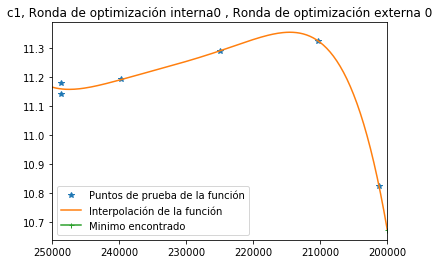

tensor([244.8199], device='cuda:0')
tensor([242.9625], device='cuda:0')
tensor([243.4220], device='cuda:0')
tensor([251.6301], device='cuda:0')
tensor([247.3018], device='cuda:0')
tensor([248.3352], device='cuda:0')


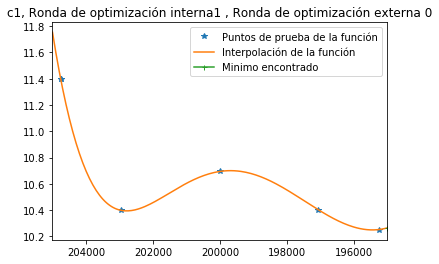

tensor([245.3313], device='cuda:0')
tensor([242.2726], device='cuda:0')
tensor([242.6495], device='cuda:0')
tensor([246.1032], device='cuda:0')
tensor([239.3415], device='cuda:0')
tensor([243.3800], device='cuda:0')


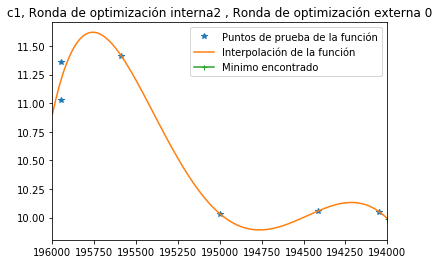

tensor([242.0094], device='cuda:0')
tensor([242.2553], device='cuda:0')
tensor([241.7254], device='cuda:0')
tensor([242.6356], device='cuda:0')
tensor([240.1516], device='cuda:0')
tensor([242.3922], device='cuda:0')


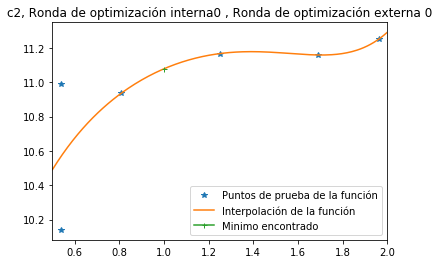

tensor([243.6990], device='cuda:0')
tensor([244.6326], device='cuda:0')
tensor([244.9623], device='cuda:0')
tensor([248.3512], device='cuda:0')
tensor([249.4205], device='cuda:0')
tensor([246.9938], device='cuda:0')


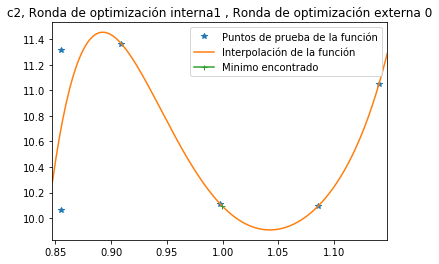

tensor([243.8972], device='cuda:0')
tensor([242.8268], device='cuda:0')
tensor([245.6139], device='cuda:0')
tensor([241.5905], device='cuda:0')
tensor([238.5161], device='cuda:0')
tensor([241.3870], device='cuda:0')


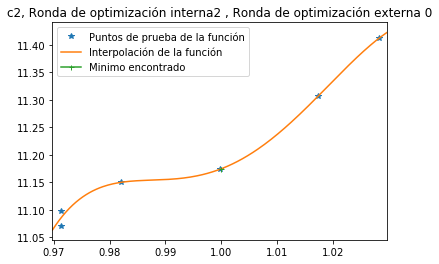

tensor([241.7669], device='cuda:0')
tensor([241.5571], device='cuda:0')
tensor([246.6864], device='cuda:0')
tensor([247.2158], device='cuda:0')
tensor([252.2880], device='cuda:0')
tensor([249.6732], device='cuda:0')


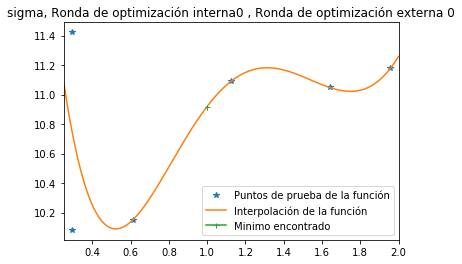

tensor([242.7015], device='cuda:0')
tensor([245.3182], device='cuda:0')
tensor([243.1306], device='cuda:0')
tensor([242.0353], device='cuda:0')
tensor([244.5743], device='cuda:0')
tensor([244.0535], device='cuda:0')


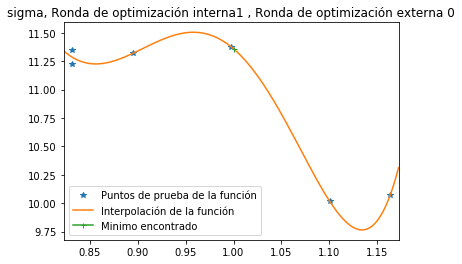

tensor([244.5335], device='cuda:0')
tensor([245.4388], device='cuda:0')
tensor([240.9818], device='cuda:0')
tensor([245.6207], device='cuda:0')
tensor([244.7915], device='cuda:0')
tensor([241.8647], device='cuda:0')


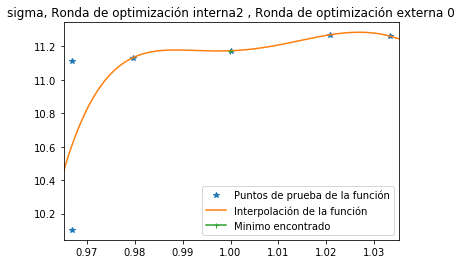

tensor([249.1770], device='cuda:0')
tensor([242.8571], device='cuda:0')
tensor([250.6862], device='cuda:0')
tensor([256.7800], device='cuda:0')
tensor([236.7425], device='cuda:0')
tensor([249.2087], device='cuda:0')


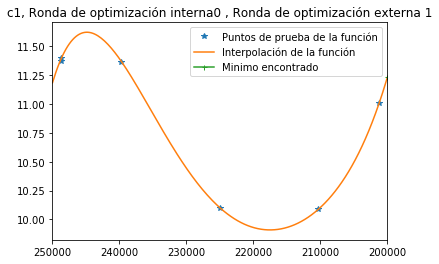

tensor([240.1490], device='cuda:0')
tensor([244.1975], device='cuda:0')
tensor([246.3349], device='cuda:0')
tensor([246.6850], device='cuda:0')
tensor([238.9917], device='cuda:0')
tensor([240.9558], device='cuda:0')


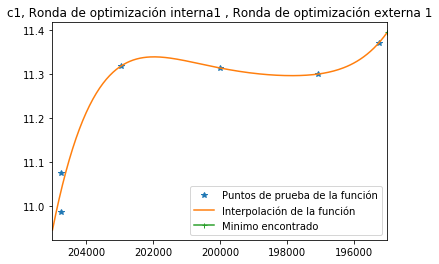

tensor([236.6112], device='cuda:0')
tensor([242.7251], device='cuda:0')
tensor([241.9912], device='cuda:0')
tensor([242.8990], device='cuda:0')
tensor([242.2767], device='cuda:0')
tensor([243.7812], device='cuda:0')


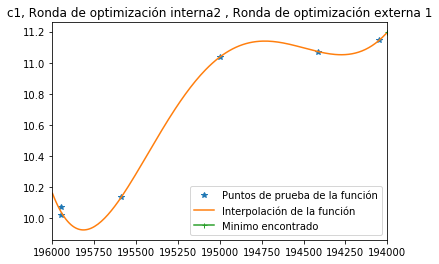

tensor([244.3341], device='cuda:0')
tensor([245.4973], device='cuda:0')
tensor([248.0246], device='cuda:0')
tensor([244.7774], device='cuda:0')
tensor([255.7095], device='cuda:0')
tensor([241.0669], device='cuda:0')


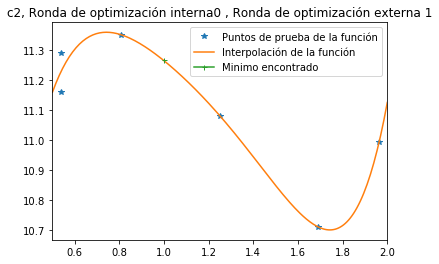

tensor([246.8619], device='cuda:0')
tensor([244.3779], device='cuda:0')
tensor([244.1099], device='cuda:0')


KeyboardInterrupt: 

In [20]:
for rondaDeOptimizacionGlobal in range(1):
    # Optimización para el parametro C1
    extremoInferiorIntervalo = 0.25e-6
    extremoSuperiorIntervalo = 5e-5
    minimoEnRonda : np.float128 = 3
    for rondaDeOptimizacion in range(3):
        anchoIntervalo = extremoSuperiorIntervalo - extremoInferiorIntervalo
        tiemposTomados = []
        valores = puntos_chebyscheff(5,extremoInferiorIntervalo,extremoSuperiorIntervalo)
        estadisticasDeSolucionesEnPDC= []
        for valor in valores:
            # redefinición de la función de actualización con el nuevo valor
            c1 = valor
            # Generación de variable con el tiempo de referencia para la nueva solución.
            t0 = time.time()
            # Reestablecimiento de los parametros de la red Neuronal
            redDinamica = NeuralNetworkPrueba().to(device)
            # Solución con el nuevo valor.
            estadisticasDeSolucionesEnPDC.append( solucionar(serializar=True))
            # Toma del tiempo de la solución.
            tiemposTomados.append(time.time()-t0)

        # Interpolación polinomica con los tiempos de la nueva solución.
        interpolacion = np.polynomial.Polynomial.fit(valores,tiemposTomados,len(valores)-1)
        
        #Generación de un eje X para las gráficas y obetner el estimado del valor minimo.
        x_grafica = np.linspace(extremoInferiorIntervalo,extremoSuperiorIntervalo,200)

        # minimo en ronda es el punto en el cual se encontro el minimo DENTRO del polinomio.
        minimoEnRonda : np.float128 = x_grafica[np.argmin(interpolacion(x_grafica))]
        c1 = minimoEnRonda

        plt.plot(valores,tiemposTomados,linewidth = 0, marker = "*",label = "Puntos de prueba de la función")
        plt.plot(x_grafica,interpolacion(x_grafica),label = "Interpolación de la función")
        plt.xlim(extremoInferiorIntervalo,extremoSuperiorIntervalo)
        plt.plot(minimoEnRonda,interpolacion(minimoEnRonda),marker = "+", ms = 5,label = "Minimo encontrado")
        plt.title(f"c1, Ronda de optimización interna{rondaDeOptimizacion} , Ronda de optimización externa {rondaDeOptimizacionGlobal}")
        nombreGuardar = f"c1, int {rondaDeOptimizacion},ext{rondaDeOptimizacionGlobal}"
        plt.legend()
        plt.savefig("RESULTADOS/parametros/graficas/"+nombreGuardar,dpi = 300)

        # Serialización de la solución
        estadisticasC1.anadir([extremoInferiorIntervalo,extremoSuperiorIntervalo],
                                minimoEnRonda,
                                interpolacion,
                                estadisticasDeSolucionesEnPDC,
                                tiemposTomados,
                                valores)
    


        # Reducción del intervalo de busqueda a un 20% para la siguiente ronda de optimización.
        extremoInferiorIntervalo = minimoEnRonda - 0.2/2 * anchoIntervalo
        extremoSuperiorIntervalo = minimoEnRonda + 0.2/2 * anchoIntervalo
        
        plt.legend()
        plt.show()
        
        
    
    # Optimización para el parametro C2
    extremoInferiorIntervalo = 0.5
    extremoSuperiorIntervalo = 2
    minimoEnRonda : np.float128 = 3
    for rondaDeOptimizacion in range(3):
        anchoIntervalo = extremoSuperiorIntervalo - extremoInferiorIntervalo
        tiemposTomados = []
        valores = puntos_chebyscheff(5,extremoInferiorIntervalo,extremoSuperiorIntervalo)
        estadisticasDeSolucionesEnPDC= []
        for valor in valores:
            # redefinición de la función de actualización con el nuevo valor
            c2 = valor
            # Generación de variable con el tiempo de referencia para la nueva solución.
            t0 = time.time()
            # Reestablecimiento de los parametros de la red Neuronal
            redDinamica = NeuralNetworkPrueba().to(device)
            # Solución con el nuevo valor.
            estadisticasDeSolucionesEnPDC.append( solucionar(serializar=True))
            # Toma del tiempo de la solución.
            tiemposTomados.append(time.time()-t0)

        # Interpolación polinomica con los tiempos de la nueva solución.
        interpolacion = np.polynomial.Polynomial.fit(valores,tiemposTomados,len(valores)-1)
        
        #Generación de un eje X para las gráficas y obetner el estimado del valor minimo.
        x_grafica = np.linspace(extremoInferiorIntervalo,extremoSuperiorIntervalo,200)

        # minimo en ronda es el punto en el cual se encontro el minimo DENTRO del polinomio.
        minimoEnRonda : np.float128 = x_grafica[np.argmin(interpolacion(x_grafica))]
        c2 = minimoEnRonda
        plt.plot(valores,tiemposTomados,linewidth = 0, marker = "*",label = "Puntos de prueba de la función")
        plt.plot(x_grafica,interpolacion(x_grafica),label = "Interpolación de la función")
        plt.xlim(extremoInferiorIntervalo,extremoSuperiorIntervalo)
        plt.plot(minimoEnRonda,interpolacion(minimoEnRonda),marker = "+", ms = 10,label = "Minimo encontrado")
        plt.title(f"c2, Ronda de optimización interna{rondaDeOptimizacion} , Ronda de optimización externa {rondaDeOptimizacionGlobal}")
        nombreGuardar = f"c2, int {rondaDeOptimizacion},ext{rondaDeOptimizacionGlobal}"
        plt.legend()
        plt.savefig("RESULTADOS/parametros/graficas/"+nombreGuardar,dpi = 300)
        plt.show()

        # Serialización de la solución
        estadisticasC2.anadir([extremoInferiorIntervalo,extremoSuperiorIntervalo],
                                minimoEnRonda,
                                interpolacion,
                                estadisticasDeSolucionesEnPDC,
                                tiemposTomados,
                                valores)
    


        # Reducción del intervalo de busqueda a un 20% para la siguiente ronda de optimización.
        extremoInferiorIntervalo = minimoEnRonda - 0.2/2 * anchoIntervalo
        extremoSuperiorIntervalo = minimoEnRonda + 0.2/2 * anchoIntervalo
        
        


    # Optimización para el parametro sigma

    #Dado que sigma es un parametro real, se va a usar la transformación sigma = 10**x y se va a optimizar x
    extremoInferiorIntervalo = -2
    extremoSuperiorIntervalo = 0
    minimoEnRonda : np.float128 = 3
    for rondaDeOptimizacion in range(3):
        anchoIntervalo = extremoSuperiorIntervalo - extremoInferiorIntervalo
        tiemposTomados = []
        valores = puntos_chebyscheff(5,extremoInferiorIntervalo,extremoSuperiorIntervalo)
        estadisticasDeSolucionesEnPDC= []
        for valor in valores:
            # redefinición de la función de actualización con el nuevo valor
            sigma = 10**valor
            # Generación de variable con el tiempo de referencia para la nueva solución.
            t0 = time.time()
            # Reestablecimiento de los parametros de la red Neuronal
            redDinamica = NeuralNetworkPrueba().to(device)
            # Solución con el nuevo valor.
            estadisticasDeSolucionesEnPDC.append( solucionar(serializar=True))
            # Toma del tiempo de la solución.
            tiemposTomados.append(time.time()-t0)

        # Interpolación polinomica con los tiempos de la nueva solución.
        interpolacion = np.polynomial.Polynomial.fit(valores,tiemposTomados,len(valores)-1)
        
        #Generación de un eje X para las gráficas y obetner el estimado del valor minimo.
        x_grafica = np.linspace(extremoInferiorIntervalo,extremoSuperiorIntervalo,200)

        # minimo en ronda es el punto en el cual se encontro el minimo DENTRO del polinomio.
        minimoEnRonda : np.float128 = x_grafica[np.argmin(interpolacion(x_grafica))]
        sigma = 10**minimoEnRonda
        plt.plot(valores,tiemposTomados,linewidth = 0, marker = "*",label = "Puntos de prueba de la función")
        plt.plot(x_grafica,interpolacion(x_grafica),label = "Interpolación de la función")
        plt.xlim(extremoInferiorIntervalo,extremoSuperiorIntervalo)
        plt.plot(minimoEnRonda,interpolacion(minimoEnRonda),marker = "+", ms = 5,label = "Minimo encontrado")
        plt.title(f"sigma, Ronda de optimización interna{rondaDeOptimizacion} , Ronda de optimización externa {rondaDeOptimizacionGlobal}")
        nombreGuardar = f"sigma, int {rondaDeOptimizacion},ext{rondaDeOptimizacionGlobal}"
        plt.legend()
        plt.savefig("RESULTADOS/parametros/graficas/"+nombreGuardar,dpi = 300)
        plt.show()

        # Serialización de la solución
        estadisticassigma.anadir([extremoInferiorIntervalo,extremoSuperiorIntervalo],
                                minimoEnRonda,
                                interpolacion,
                                estadisticasDeSolucionesEnPDC,
                                tiemposTomados,
                                valores)
    


        # Reducción del intervalo de busqueda a un 20% para la siguiente ronda de optimización.
        extremoInferiorIntervalo = minimoEnRonda - 0.2/2 * anchoIntervalo
        extremoSuperiorIntervalo = minimoEnRonda + 0.2/2 * anchoIntervalo
        
        


print(f"empezo a serializar en {os.getcwd()}")
pickle.dump("Estadisticas c1",archivo)
pickle.dump(estadisticasC1,archivo)
pickle.dump("Estadisticas c2",archivo)
pickle.dump(estadisticasC2,archivo)
pickle.dump("Estadisticas sigma",archivo)
pickle.dump(estadisticassigma,archivo)
print("Termino de serializar")

archivo.close()

## Comparación contra la solución no optimizada y la solución a partir de puntos aleatorios

Para la comparación contra la solución no optimizada se va a observar la convergencia en tiempo de cada función. Para esto se va a grabar como avanza la solucion vs las epocas y vs el tiempo.

In [ ]:
puntosAleatorios = torch.rand(40)
def actualizarPuntosAleatorios():
    global puntosAleatorios
    puntosAleatorios = torch.rand(40)
def solucionarPuntosAleatorios():
    pass

In [1]:
class ultimaComparacion():
    def __init__(self,nombresito):
        self.tiempos = []
        self.registrosPerdidasGlobales = []
        self.nombre = nombresito
        self.frecuenciaSampleo = 200 # Sampleo cada 200 datos
        pass
    def anadirDato(self,tiempo,perdida):
        self.tiempos.append(tiempo)
        self.registrosPerdidasGlobales.append(perdida)

metodoTradicional = []
metodoUsado = []
for i in range(5):
    metodoTradicional.append(ultimaComparacion("Función de densidad de probabilidad uniforme"))
    metodoUsado.append(ultimaComparacion("Función de densidad de probabilidad móvil"))

for i in range(5):

    
    optimizer = torch.optim.Adam(redDinamica.parameters(), lr=learningRate)
    if serializar:
       registro_perdida=[]
       registro_promedio=[]
    tiempoInicial = time.time()
    i = 0
    termino = False
    while time.time()-tiempoInicial<3600*1.75 and not termino and estaResolviendo:
        # Compute prediction and loss
        loss = perdidaConPesos()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            #print(loss.item()/len(puntos))
            #print("supermax",promAct)
            actualizarPuntosConPesos()
        if i % 20 == 0:
            if serializar:
                registro_perdida.append(perdidaParaRevisar().item()/len(puntos))
                registro_promedio.append(promAct)
            else:
                inutil = perdidaParaRevisar().item()/len(puntos)
            termino = revisador()
            print(varPerdidaCondicionParada)
        if i % 300 == 0:
            if serializar:
                nombreParaGuardarRedIntermedia = "RESULTADOS/parametros/redesIntermedias/senoParalelo"+str(i)+" epochs variable "+variable+"ronda"+ronda +".tar"
                torch.save(redDinamica.state_dict(),nombreParaGuardarRedIntermedia)
        i+=1
estaResolviendo = True
solucionar(serializar=True,variable = "prueba",ronda=-2)



In [26]:
extremoInferiorIntervalo = 0.5e-5
extremoSuperiorIntervalo = 1e-3
minimoEnRonda : np.float128 = 3

def puntos_chebyscheff(n,a,b):
    inicializacion = np.array(range(n+1))
    inicializacion = np.flip(inicializacion)
    return (a +b + (b-a)*np.cos(np.pi/(n+1)*(inicializacion + 0.5)))/2
c2 = 1
sigma = 0.25
for rondaDeOptimizacion in range(3):
    anchoIntervalo = extremoSuperiorIntervalo - extremoInferiorIntervalo
    tiemposTomados = []
    valores = puntos_chebyscheff(8,extremoInferiorIntervalo,extremoSuperiorIntervalo)
    print(valores)
    estadisticasDeSolucionesEnPDC= []
    for valor in valores:
        # redefinición de la función de actualización con el nuevo valor
        c1 = valor
        # Generación de variable con el tiempo de referencia para la nueva solución.
        t0 = time.time()
        print(f"Empezo {valor}")
        for variableInutil in range(2):
            # Reestablecimiento de los parametros de la red Neuronal
            puntos = torch.linspace(0,0.5,15)
            redDinamica = NeuralNetworkPrueba().to(device)
            # Solución con el nuevo valor.
            estadisticasDeSolucionesEnPDC.append( solucionar(serializar=True))
            print(f"Termino una ronda en {time.time()-t0}")
            # Toma del tiempo de la solución.
        tiemposTomados.append(time.time()-t0)
        

    # Interpolación polinomica con los tiempos de la nueva solución.
    interpolacion = np.polynomial.Polynomial.fit(valores,tiemposTomados,len(valores)-1)
    
    #Generación de un eje X para las gráficas y obetner el estimado del valor minimo.
    x_grafica = np.linspace(extremoInferiorIntervalo,extremoSuperiorIntervalo,200)

    # minimo en ronda es el punto en el cual se encontro el minimo DENTRO del polinomio.
    minimoEnRonda : np.float128 = x_grafica[np.argmin(interpolacion(x_grafica))]
    c1 = minimoEnRonda

    plt.plot(valores,tiemposTomados,linewidth = 0, marker = "*",label = "Puntos de prueba de la función")
    plt.plot(x_grafica,interpolacion(x_grafica),label = "Interpolación de la función")
    plt.xlim(extremoInferiorIntervalo,extremoSuperiorIntervalo)
    plt.plot(minimoEnRonda,interpolacion(minimoEnRonda),marker = "+", ms = 5,label = "Minimo encontrado")
    plt.title(f"c1, Ronda de optimización interna{rondaDeOptimizacion} , Ronda de optimización externa {rondaDeOptimizacionGlobal}")
    nombreGuardar = f"c1, int {rondaDeOptimizacion},ext{rondaDeOptimizacionGlobal}"
    plt.legend()
    plt.savefig("RESULTADOS/parametros/graficas/"+nombreGuardar,dpi = 300)

    # Serialización de la solución
    estadisticasC1.anadir([extremoInferiorIntervalo,extremoSuperiorIntervalo],
                            minimoEnRonda,
                            interpolacion,
                            estadisticasDeSolucionesEnPDC,
                            tiemposTomados,
                            valores)



    # Reducción del intervalo de busqueda a un 20% para la siguiente ronda de optimización.
    extremoInferiorIntervalo = minimoEnRonda - 0.2/2 * anchoIntervalo
    extremoSuperiorIntervalo = minimoEnRonda + 0.2/2 * anchoIntervalo
    
    plt.legend()
    plt.show()
        

[1.25581429e-05 7.16523616e-05 1.82713164e-04 3.32344979e-04
 5.02500000e-04 6.72655021e-04 8.22286836e-04 9.33347638e-04
 9.92441857e-04]
Empezo 1.255814287642648e-05


KeyboardInterrupt: 

array([0.01703709, 0.14644661, 0.37059048, 0.62940952, 0.85355339,
       0.98296291])